## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [18]:
#--- INSTALATION INSTRUCTIONS ---#

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.5 qiskit-machine-learning==0.8.4 'qiskit-machine-learning[sparse]' torch matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

#--- Imports ---#
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram
from qiskit import qpy

from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient, SPSAEstimatorGradient

import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import os

In [ ]:
#- Visualization configuration -#

# Visualization configuration dict
visual_config = {
    'draw_circuits': True,
    'draw_probs': True,
    'train': False,
    'draw_results': True
}

In [ ]:
#- Configuration -#

# Training configuration dict
train_config = {
    'execution_type': "noiseless_simulation",
    'n_qubits': 4,
    'seed': 1,
    'id': None, # For different circuits or training parameters
    'reset_data': False,

    'create_circuits': False, # Create circuits manually or load from file
    'gradient_method': "PSR", # PSR or SPSA
    'max_iterations': 1000,
    'gen_iterations': 1,
    'disc_iterations': 1,
    'save_loss_iterations': 10, # Calculate extra forward pass to save loss
    'print_progress_iterations': 10,

    'training_data_file': None, # Automatically created with manage_files function
    'circuits_file': None # Automatically created with manage_files function
}

# File management
def manage_files(data_folder_name = 'data', implementation_name = 'fullyq_torch', execution_type_name = 'sim', training_data_file_name = 'training_data', circuits_file_name = 'circuits'):
    data_folder = data_folder_name + '/' + implementation_name + '/' + execution_type_name + '/' + 'q' + str(train_config['n_qubits']) + '/' + 'seed' + str(train_config['seed']) + '/'
    if train_config['id'] is not None:
        data_folder = data_folder + '/' + str(train_config['id']) + '/' 
    training_data_file = data_folder + training_data_file_name + '.pth'
    circuits_file = data_folder + circuits_file_name + '.qpy'

    # Create folders if they do not exist
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    return training_data_file, circuits_file

train_config['training_data_file'], train_config['circuits_file'] = manage_files()

In [21]:
#- Create quantum circuits -#

# Create real data sample circuit
def generate_real_circuit():
    n_qubits = train_config['n_qubits']

    # sv = random_statevector(2**N_QUBITS, seed=SEED)
    # qc = QuantumCircuit(N_QUBITS)
    # qc.prepare_state(sv, qc.qubits, normalize=True)

    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits-1))
    qc.cx(n_qubits-2, n_qubits-1)
    return qc


# Create generator
def generate_generator():
    n_qubits = train_config['n_qubits']

    qc = RealAmplitudes(n_qubits,
                        reps=3, # Number of layers
                        parameter_prefix='θ_g',
                        name='Generator')
    
    return qc.decompose()


# Create discriminator
def generate_discriminator():
    n_qubits = train_config['n_qubits']

    qc = EfficientSU2(n_qubits,
                      entanglement="reverse_linear",
                      reps=1, # Number of layers
                      parameter_prefix='θ_d',
                      name='Discriminator').decompose()


    param_index = qc.num_parameters

    for i in reversed(range(n_qubits - 1)):
        qc.cx(i, n_qubits - 1)

    #qc.rx(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.ry(Parameter("θ_d["+str(param_index)+"]"), n_qubits-1); param_index += 1
    qc.rz(Parameter("θ_d["+str(param_index)+"]"), n_qubits-1); param_index += 1
    
    return qc


# Create quantum circuits
def create_circuits():
    real_circuit = generate_real_circuit()
    generator_circuit = generate_generator()
    discriminator_circuit = generate_discriminator()

    with open(train_config['circuits_file'], 'wb') as fd:
        qpy.dump([real_circuit, generator_circuit, discriminator_circuit], fd)

# Load circuits
if train_config['create_circuits']:
    create_circuits()

try:
    with open(train_config['circuits_file'], 'rb') as fd:
        circuits = qpy.load(fd)
except FileNotFoundError:
    print("Circuits file not found. Creating new circuits file.")
    create_circuits()
    with open(train_config['circuits_file'], 'rb') as fd:
        circuits = qpy.load(fd)
    
real_circuit = circuits[0]
generator_circuit = circuits[1]
discriminator_circuit = circuits[2]

In [ ]:
#- Set up training quantum circuits -#
def generate_training_circuits(real_circuit, generator_circuit, discriminator_circuit):
    n_qubits = train_config['n_qubits']

    # Connect real data and discriminator
    real_disc_circuit = QuantumCircuit(n_qubits)
    real_disc_circuit.compose(real_circuit, inplace=True)
    real_disc_circuit.compose(discriminator_circuit, inplace=True)

    # Connect generator and discriminator
    gen_disc_circuit = QuantumCircuit(n_qubits)
    gen_disc_circuit.compose(generator_circuit, inplace=True)
    gen_disc_circuit.compose(discriminator_circuit, inplace=True)

    # Use EstimatorQNN to compile the circuit and handle gradient calculation
    estimator = StatevectorEstimator()

    if train_config['gradient_method'] == 'SPSA':
        gradient = SPSAEstimatorGradient(estimator=estimator)
    else:
        gradient = ParamShiftEstimatorGradient(estimator=estimator)

    H1 = SparsePauliOp.from_list([("Z" + "I"*(n_qubits-1), 1.0)])
    N_DPARAMS = discriminator_circuit.num_parameters

    # specify QNN to update generator parameters
    gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                        input_params=gen_disc_circuit.parameters[:N_DPARAMS], # fixed parameters (discriminator parameters)
                        weight_params=gen_disc_circuit.parameters[N_DPARAMS:], # parameters to update (generator parameters)
                        estimator=estimator,
                        observables=[H1],
                        gradient=gradient,
                        default_precision=0.0
                        )

    # specify QNN to update discriminator parameters regarding to fake data
    disc_fake_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                            input_params=gen_disc_circuit.parameters[N_DPARAMS:], # fixed parameters (generator parameters)
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )

    # specify QNN to update discriminator parameters regarding to real data
    disc_real_qnn = EstimatorQNN(circuit=real_disc_circuit,
                            input_params=[], # no input parameters
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H1],
                            gradient=gradient,
                            default_precision=0.0
                            )
    
    return gen_qnn, disc_fake_qnn, disc_real_qnn

gen_qnn, disc_fake_qnn, disc_real_qnn = generate_training_circuits(real_circuit, generator_circuit, discriminator_circuit)

In [ ]:
#- Restore parameters and model states -#

# Reset all data training
def reset_data(n_gen_params, n_disc_params):
    np.random.seed(train_config['seed'])

    init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(n_gen_params,))
    init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(n_disc_params,))

    gen_params = torch.tensor(init_gen_params, requires_grad=True)
    disc_params = torch.tensor(init_disc_params, requires_grad=True)

    optimizer_g = torch.optim.Adam([gen_params], lr=0.005)
    optimizer_d = torch.optim.Adam([disc_params], lr=0.005)

    torch.save({
        'init_gen_params': init_gen_params,
        'init_disc_params': init_disc_params,
        'gen_params': gen_params,
        'disc_params': disc_params,
        'best_gen_params': init_gen_params,
        'optimizer_g_state': optimizer_g.state_dict(),
        'optimizer_d_state': optimizer_d.state_dict(),
        'current_epoch': 0,
        "metrics": {
            "gloss": {},
            "dloss": {},
            "kl_div": {},
        },
        'random_state': np.random.get_state()
    }, train_config['training_data_file'])


# Load parameters and training states
if train_config['reset_data']:
    reset_data(generator_circuit.num_parameters, discriminator_circuit.num_parameters)

try:
    params = torch.load(train_config['training_data_file'], weights_only=False)
except FileNotFoundError:
    print("Training data file not found. Resetting parameters.")
    reset_data(generator_circuit.num_parameters, discriminator_circuit.num_parameters)
    params = torch.load(train_config['training_data_file'], weights_only=False)

np.random.set_state(params['random_state'])

gen_params = params['gen_params']
disc_params = params['disc_params']

optimizer_g = torch.optim.Adam([gen_params])
optimizer_d = torch.optim.Adam([disc_params])

optimizer_g.load_state_dict(params['optimizer_g_state'])
optimizer_d.load_state_dict(params['optimizer_d_state'])

current_epoch = params['current_epoch']
gloss = params['metrics']['gloss']
gen_loss = list(gloss)[-1] if (gloss) else None
dloss = params['metrics']['dloss']
disc_loss = list(dloss)[-1] if (dloss) else None
kl_div = params['metrics']['kl_div']
min_kl_div = np.min(list(kl_div.values())) if (kl_div) else float('inf')

In [24]:
#- Manage training interruption -#
import signal

# Class to manage training interruption
class Interrupter:
    def __init__(self):
        self.kill_now = False
        self.interrupt_count = 0

        # Intercept the Ctrl+C signal
        signal.signal(signal.SIGINT, self.handle_signal)
        # Intercept the termination signal (useful for Docker/systems)
        #signal.signal(signal.SIGTERM, self.handle_signal)

    def handle_signal(self, signum, frame):
        self.interrupt_count += 1
        
        if self.interrupt_count == 1:
            # First Press: Enable graceful exit
            self.kill_now = True
            print("\nInterrupter: Termination signal received. The loop will stop after the current iteration. (Press Ctrl+C again to force quit)")
        
        elif self.interrupt_count >= 2:
            # Second Press: Force quit immediately
            print("\nInterrupter: [!] Force quit triggered! Terminating immediately.")
            # Restore default signal handler to avoid recursion
            signal.signal(signal.SIGINT, signal.SIG_DFL)
            # Raise the exception to stop execution right here
            raise KeyboardInterrupt

In [ ]:
#- Training -#

if visual_config['train']:

    D_STEPS = train_config['disc_iterations']
    G_STEPS = train_config['gen_iterations']
    C_STEPS = train_config['save_loss_iterations']

    real_distribution_tensor = torch.from_numpy(Statevector(real_circuit).probabilities()) # Retrieve real data probability distribution 

    interrupter = Interrupter()

    if train_config['print_progress_iterations']:
        TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
        print(TABLE_HEADERS)
    start_time = time.time()

    #--- Training loop ---#
    try: # In case of interruption
        for epoch in range(current_epoch, train_config['max_iterations']+1):

            #--- Quantum discriminator parameter updates ---#
            for disc_train_step in range(D_STEPS):
                # Calculate discriminator cost
                if (disc_train_step == D_STEPS-1) and (epoch % C_STEPS == 0):
                    value_dcost_fake = disc_fake_qnn.forward(gen_params.detach(), disc_params.detach())[0,0]
                    value_dcost_real = disc_real_qnn.forward([], disc_params.detach())[0,0]
                    disc_loss = ((value_dcost_real - value_dcost_fake)-2)/4
                    dloss[epoch] = disc_loss

                # Caltulate discriminator gradient
                grad_dcost_fake = disc_fake_qnn.backward(gen_params.detach(), disc_params.detach())[1][0,0]
                grad_dcost_real = disc_real_qnn.backward([], disc_params.detach())[1][0,0]
                grad_dcost = grad_dcost_real - grad_dcost_fake
                grad_dcost = torch.tensor(grad_dcost)
                
                # Update discriminator parameters
                optimizer_d.zero_grad()
                disc_params.grad = grad_dcost.to(dtype=disc_params.dtype, device=disc_params.device)
                optimizer_d.step()

            #--- Quantum generator parameter updates ---#
            for gen_train_step in range(G_STEPS):
                # Calculate generator cost
                if (gen_train_step == G_STEPS-1) and (epoch % C_STEPS == 0):
                    value_gcost = gen_qnn.forward(disc_params.detach(), gen_params.detach())[0,0]
                    gen_loss = (value_gcost-1)/2
                    gloss[epoch] = gen_loss

                # Calculate generator gradient
                grad_gcost = gen_qnn.backward(disc_params.detach(), gen_params.detach())[1][0,0]
                grad_gcost = torch.tensor(grad_gcost)

                # Update generator parameters
                optimizer_g.zero_grad()
                gen_params.grad = grad_gcost.to(dtype=gen_params.dtype, device=gen_params.device)
                optimizer_g.step()


            #--- Track KL and save best performing generator weights ---#
            gen_distribution_tensor = torch.from_numpy(Statevector(generator_circuit.assign_parameters(gen_params.detach().numpy())).probabilities()) # Retrieve probability distribution of generator with current parameters.

            # 3. Move to GPU (The speedup for large vectors is massive)
            # if torch.cuda.is_available():
            #     p = p.cuda()
            #     q = q.cuda()

            # Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions
            current_kl = torch.nn.functional.kl_div(input=gen_distribution_tensor.log(), target=real_distribution_tensor, reduction='sum').numpy() # reduction="batchnoseque" pa batches
            kl_div[epoch] = current_kl
            if min_kl_div > current_kl:
                min_kl_div = current_kl
                best_gen_params = gen_params.detach().numpy() # New best


            #--- Print progress ---#
            if train_config['print_progress_iterations'] and (epoch % train_config['print_progress_iterations'] == 0):
                for header, val in zip(TABLE_HEADERS.split('|'),
                                    (epoch, gen_loss, disc_loss, current_kl, min_kl_div, (time.time() - start_time))):
                    print(f"{val:.3g} ".rjust(len(header)), end="|")
                start_time = time.time()
                print()

            # In case of interruption
            if interrupter.kill_now:
                print("Interrupter: Graceful exit triggered. Breaking loop.")
                break
                
    #--- Save parameters and optimizer states data ---#
    finally:
        torch.save({
            'init_gen_params': params['init_gen_params'],
            'init_disc_params': params['init_disc_params'],
            'best_gen_params': best_gen_params,
            'gen_params': gen_params,
            'disc_params': disc_params,
            'optimizer_g_state': optimizer_g.state_dict(),
            'optimizer_d_state': optimizer_d.state_dict(),
            'current_epoch': epoch+1,
            "metrics": {
                "gloss": gloss,
                "dloss": dloss,
                "kl_div": kl_div,
            },
            'random_state': np.random.get_state()
        }, train_config['training_data_file'])
        
        kl_div_data = list(kl_div.values())
        print("Training complete:", "\n   Data path:", train_config['training_data_file'], "\n   Best KLDiv:", np.min(kl_div_data), "in epoch", np.argmin(kl_div_data), "\n   Improvement:", kl_div_data[0]-np.min(kl_div_data))

Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
    0 |         -0.534 |             -0.543 |    1.76 |         1.76 |0.987 |
   10 |         -0.547 |             -0.555 |    1.98 |         1.76 | 7.58 |
   20 |         -0.554 |             -0.567 |    2.63 |         1.76 | 3.69 |

Interrupter: Termination signal received. The loop will stop after the current iteration. (Press Ctrl+C again to force quit)
Interrupter: Graceful exit triggered. Breaking loop.
Training complete: 
   Data path: data/fullyq_torch/sim/q4/seed1//testing/training_data.pth 
   Best KLDiv: 1.7597088724808336 in epoch 0 
   Improvement: 0.0


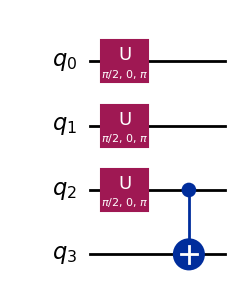

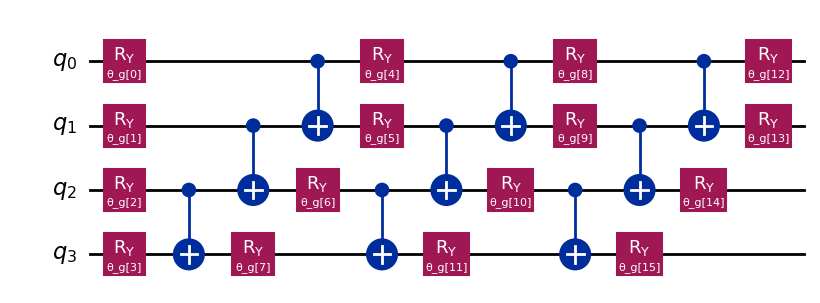

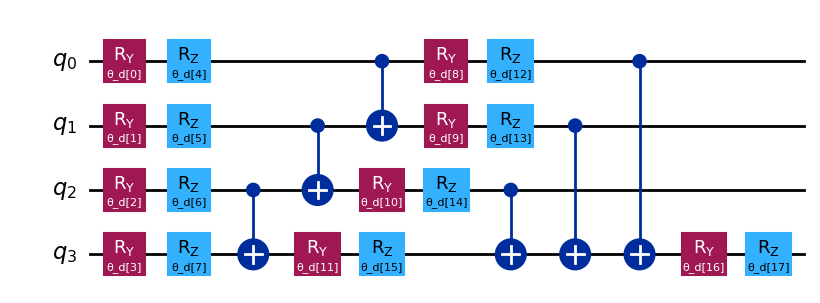

[-0.51958925  0.36875907 -2.2595155  -1.89688429  1.88963386  2.94217425
 -1.17229046  1.20839863  2.36492279  2.47938679 -2.60724411 -2.89620421
 -2.07451666  2.37593942 -2.52366127 -0.49569541  2.87700477  0.20838363]


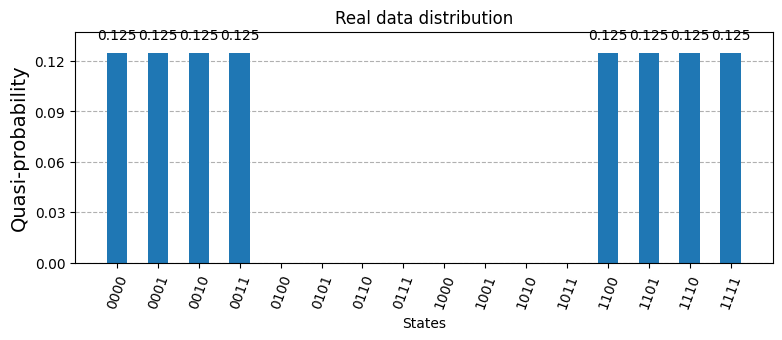

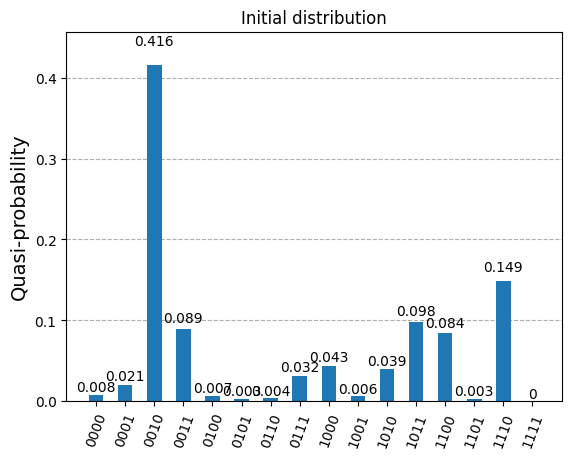

In [26]:
#- Circuits visualization -#

# Real data circuit
if visual_config['draw_circuits']:
    display(real_circuit.decompose(reps=5).draw('mpl'))

# Real data circuit probability distribution
if visual_config['draw_probs']:
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**train_config['n_qubits']):
                key = format(n, 'b').zfill(train_config['n_qubits'])
                if key not in dict.keys():
                    dict[key] = 0.0

    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    prepare_dicts([real_prob_dict])
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 3))
    ax1.set_title("Real data distribution")
    ax1.set_xlabel("States")
    ax1.set_ylabel("Probabilities")
    plot_histogram(real_prob_dict, ax=ax1)


# Generator circuit
if visual_config['draw_circuits']:
    display(generator_circuit.draw('mpl'))

# Generator initial probability distribution
if visual_config['draw_probs']:
    init_gen_circuit = generator_circuit.assign_parameters(params['init_gen_params'])
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_prob_dict, ax=ax1)


# Discriminator circuit
if visual_config['draw_circuits']:
    display(discriminator_circuit.draw('mpl'))

# Discriminator initial parameters
print(params['init_disc_params'])

Training complete: data/fullyq_torch/sim/q4/seed1//testing/training_data.pth 
Best KLDiv: 1.7597088724808336 in epoch 0 
Improvement: 0.0


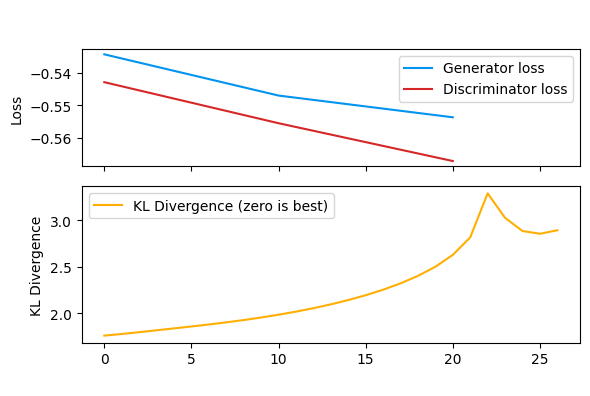

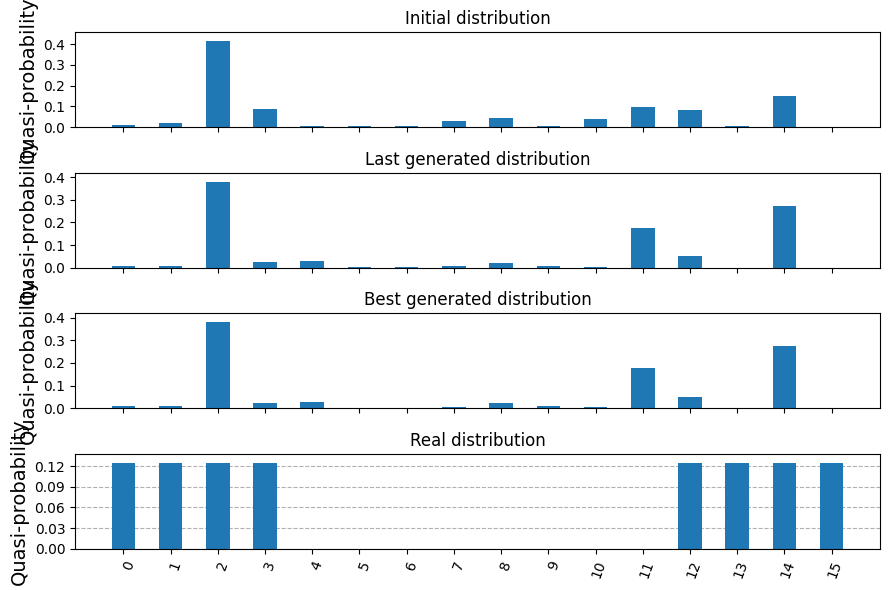

In [30]:
#- Training visualizartion -#

# Visualize training progress
if visual_config['draw_results']:
        gloss = params['metrics']['gloss']
        dloss = params['metrics']['dloss']
        kl_div = params['metrics']['kl_div']

        gloss_ax = list(gloss.keys())
        gloss_data = list(gloss.values())
        dloss_ax = list(dloss.keys())
        dloss_data = list(dloss.values())
        kl_div_ax = list(kl_div.keys())
        kl_div_data = list(kl_div.values())

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        fig.suptitle('QGAN training stats', color="#ffffffff")
        kl.set_xlabel("Epochs", color="#ffffffff")
        loss.plot(gloss_ax, gloss_data, label="Generator loss", color="#0094f0ff")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(kl_div_ax, kl_div_data, label="KL Divergence (zero is best)", color="#ffaf01ff")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

        print("Training complete:", train_config['training_data_file'], "\nBest KLDiv:", np.min(kl_div_data), "in epoch", np.argmin(kl_div_data), "\nImprovement:", kl_div_data[0]-np.min(kl_div_data))



# Analyze generator circuit with new parameters
if visual_config['draw_results']:

    dict1 = Statevector(generator_circuit.assign_parameters(params['init_gen_params'])).probabilities_dict()
    dict2 = Statevector(generator_circuit.assign_parameters(params['gen_params'].detach().numpy())).probabilities_dict()
    dict3 = Statevector(generator_circuit.assign_parameters(best_gen_params)).probabilities_dict()
    dict4 = Statevector(real_circuit).probabilities_dict()
    
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**train_config['n_qubits']):
                key = format(n, 'b').zfill(train_config['n_qubits'])
                if key not in dict.keys():
                    dict[n] = 0.0
                else:
                    dict[n] = dict[key]
                    del dict[key]
        

    prepare_dicts([dict1, dict2, dict3, dict4])

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, sharex=True, figsize=(9,6))
    
    ax1.set_ylabel('Probabilities')
    ax1.set_title("Initial distribution")
    ax2.set_title("Last generated distribution")
    ax3.set_title("Best generated distribution")
    ax4.set_title("Real distribution")
    plot_histogram(dict1, ax=ax1, bar_labels=False)
    plot_histogram(dict2, ax=ax2, bar_labels=False)
    plot_histogram(dict3, ax=ax3, bar_labels=False)
    plot_histogram(dict4, ax=ax4, bar_labels=False)
    fig.tight_layout()